# Excess mortality in different countries during the covid19 pandemics

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import matplotlib

from matplotlib.patches import Polygon
from sklearn.linear_model import LinearRegression
import datetime
import statsmodels.api as sm

In [2]:
import math

def round_to_n(x, n):
    if x==0:
        return 0
    if np.isnan(x):
        return np.nan
    else:
        return round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))

In [3]:
df = pd.read_csv('https://github.com/akarlinsky/world_mortality/blob/main/world_mortality.csv?raw=true')

df_population = pd.read_csv('https://github.com/datasets/population/blob/master/data/population.csv?raw=true')

df_official = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv?raw=true')

In [4]:
# Week of the first official covid19 death, to start the excess mortality calculation

def get_excess_begin(country, datapoints_per_year = 53):
#     if country=='Hong Kong':  # Very few deaths, but part of China
#         return 1
#     if country=='Macao':      # No deaths at all, but part of China
#         return 1
#     if country=='Mauritius':  # Fewer than 10 official deaths
#         return 3  
#     if country=='Mongolia':   # Fewer than 10 official deaths
#         return 3 
#     if country=='Taiwan':     # Fewer than 10 official deaths
#         return 3 
    if country=='Bolivia':    # April is missing
        return 3  # For Bolivia this means May, because April is missing
        
    mm = {'Bosnia':'Bosnia and Herzegovina'}
    country_lookup = country if country not in mm else mm[country]
    
    if datapoints_per_year > 12:
        d = df_official[(df_official['location']==country_lookup) 
                      & (df_official['total_deaths']>0)]['date'].values[0]
        beg = datetime.date(2020, int(d[5:7]), int(d[8:10])).isocalendar()[1]
    
    elif datapoints_per_year == 12:
#         d = df_official[(df_official['location']==country_lookup) 
#                       & (df_official['total_deaths']>10)]['date'].values[0]
#         if int(d[8:10]) > 25:
#             beg = int(d[5:7]) + 1
#         else:
#             beg = int(d[5:7])
#         beg -= 1
        beg = 2  # March
        
    elif datapoints_per_year == 4:
        beg = 0 
        
    return beg

In [5]:
def predict(X, country, verbose=False):    
    # Fit regression model on pre-2020 data 
    ind = (X[:,0] < 2020) & (X[:,1]<53)
    m = np.max(X[ind,1])
    onehot = np.zeros((np.sum(ind), m))
    for i,k in enumerate(X[ind,1]):
        onehot[i,k-1] = 1
    predictors = np.concatenate((X[ind,:1], onehot), axis=1)
    reg = LinearRegression(fit_intercept=False).fit(predictors, X[ind,2])
    
    if verbose:
        est = sm.OLS(X[ind,2], predictors)
        est = est.fit()
        print(est.summary())
    
    # Compute 2020 baseline
    ind2 = X[:,0] == 2020
    predictors2020 = np.concatenate((np.ones((m,1))*2020, np.eye(m)), axis=1)
    baseline = reg.predict(predictors2020)
            
    # Week 53 usually does not have enough data, so we'll use 
    # the same baseline value as for week 52
    if np.max(X[:,1])==53:
        baseline = np.concatenate((baseline, [baseline[-1]]))
        
    # for Ireland week 1 is missing for unclear reason
    if np.min(X[ind,1])==2:
        baseline[0] = baseline[1]
    
    # Excess mortality
    ind2 = X[:,0] == 2020
    diff2020 = X[ind2,2] - baseline[X[ind2,1]-1]
    ind3 = X[:,0] == 2021
    diff2021 = X[ind3,2] - baseline[X[ind3,1]-1]
    excess_begin = get_excess_begin(country, baseline.size)
    total_excess = np.sum(diff2020[excess_begin:]) + np.sum(diff2021)
        
    # Manual fit for uncertainty computation
    # Ireland is excluded because it has some weeks missing
    if np.unique(X[ind,0]).size > 1 and country != 'Ireland':
        y = X[ind,2][:,np.newaxis]
        beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ y
        yhat = predictors @ beta
        sigma2 = np.sum((y-yhat)**2) / (y.size-predictors.shape[1])
        
        S = np.linalg.inv(predictors.T @ predictors)
        w = np.zeros((m, 1))
        w[X[(X[:,0] == 2020) & (X[:,1] < 53),1]-1] = 1
        if np.max(X[:,1])==53:
            w[52-1] += 1
        w[:excess_begin] = 0
        w[X[ind3,1]-1] += 1
        p = 0
        for i,ww in enumerate(w):
            p += predictors2020[i] * ww
        p = p[:,np.newaxis]
        predictive_var = sigma2 * np.sum(w) + sigma2 * p.T @ S @ p
        total_excess_std = np.sqrt(predictive_var)[0][0]
    else:
        total_excess_std = np.nan
       
    return baseline, total_excess, excess_begin, total_excess_std

In [6]:
countries = np.unique(df['country_name'])
print(countries.size, '\n')

allcountries = {}

for i, country in enumerate(countries):
    print(country, end=', ' if i<countries.size-1 else '')
    if (i+1)%8 == 0:
        print('')
        
    assert(np.unique(df[(df['country_name']==country)]['time_unit']).size == 1)
    
    X = df[(df['country_name']==country)][['year','time','deaths']].values
    X = X[~np.isnan(X[:,2]),:]
    X = X.astype(int)
        
    baseline, total_excess, excess_begin, total_excess_std = predict(X, country)
        
    if country=='Belgium':
        total_excess -= 1500 # np.sum(X[X[:,0]==2020, 2][31:34] - baseline[31:34]) # 1537
    if country=='Armenia':
        # https://en.wikipedia.org/wiki/Casualties_of_the_2020_Nagorno-Karabakh_war
        total_excess -= 4000 # 3360
    if country=='Azerbaijan':
        total_excess -= 4000 # (2854+50)

    allcountries[country] = [X, baseline, total_excess, excess_begin, total_excess_std]

79 

Albania, Armenia, Australia, Austria, Azerbaijan, Belarus, Belgium, Bolivia, 
Bosnia, Brazil, Bulgaria, Canada, Chile, Colombia, Costa Rica, Croatia, 
Cyprus, Czechia, Denmark, Ecuador, Egypt, Estonia, Finland, France, 
Georgia, Germany, Greece, Hong Kong, Hungary, Iceland, Iran, Ireland, 
Israel, Italy, Japan, Kazakhstan, Kosovo, Kyrgyzstan, Latvia, Liechtenstein, 
Lithuania, Luxembourg, Macao, Malaysia, Malta, Mauritius, Mexico, Moldova, 
Mongolia, Montenegro, Netherlands, New Zealand, North Macedonia, Norway, Oman, Peru, 
Philippines, Poland, Portugal, Qatar, Romania, Russia, San Marino, Serbia, 
Singapore, Slovakia, Slovenia, South Africa, South Korea, Spain, Sweden, Switzerland, 
Taiwan, Thailand, Ukraine, United Kingdom, United States, Uruguay, Uzbekistan

In [7]:
# Export the baselines

with open('baselines.csv','w') as f:
    for c in allcountries:
        X, baseline, total_excess, excess_begin, total_excess_std = allcountries[c] 
        for i,b in enumerate(baseline):
            f.write(f'{c}, {i+1}, {b:.1f}\n')

In [8]:
# # 2021 data present

# for c in allcountries:
#     if allcountries[c][0][-1][0]==2021:
#         print(c)

In [9]:
# Population

mm = {'South Korea':'Korea, Rep.',
      'Slovakia':'Slovak Republic',
      'Russia':'Russian Federation',
      'Iran':'Iran, Islamic Rep.',
      'Czechia':'Czech Republic',
      'Egypt':'Egypt, Arab Rep.',
      'Hong Kong':'Hong Kong SAR, China',
      'Bosnia':'Bosnia and Herzegovina',
      'Kyrgyzstan':'Kyrgyz Republic',
      'Macao':'Macao SAR, China'}

pops = np.zeros(len(allcountries.keys()))
for i,m in enumerate(allcountries.keys()):
    # Russia's population should include Crimea because mortality figures do 
    if m=='Russia':
        pops[i] = 146748590 # Rosstat, estimate for 1 Jan 2020    
    elif m in mm:
        pops[i] = df_population[df_population['Country Name']==mm[m]]['Value'].values[-1]
    elif m=='Taiwan':
        pops[i] = 23568378 # Wikipedia 
    else:
        pops[i] = df_population[df_population['Country Name']==m]['Value'].values[-1]

In [10]:
# np.unique(df_population['Country Name'])

In [11]:
# Daily reported numbers during the same time period

mm = {'Bosnia':'Bosnia and Herzegovina'}

official = np.zeros(len(allcountries.keys()))
for i,m in enumerate(allcountries.keys()):
    howmany = np.max(allcountries[m][0][:,1])
    last = allcountries[m][0][-1][1]
    lastyear = allcountries[m][0][-1][0]
    
    if howmany > 12:
        d = f'{lastyear}-W{last:02}'
        r = datetime.datetime.strptime(d + '-0', "%G-W%V-%w")
        r = str(r)[:10]
    elif howmany == 12:
        if m=='Brazil': # !!!!!!!!!!!!!TEMPORARY FIX!!!!!!!!!!!!!!!!!
            r = f'{lastyear}-{last:02}-31' 
        elif last < 12:
            r = f'{lastyear}-{last+1:02}-01'
        else:
            r = f'{lastyear+1}-01-01'
    elif howmany == 4:
        if m == 'Iran':
            # https://twitter.com/Mahan_Ghafari/status/1336338070249951236
            r = '2020-09-21'
        else:
            if last < 4:
                r = f'{lastyear}-{last*3+1:02}-01'
            else:
                r = f'{lastyear+1}-01-01'
    else:
        r = ''
        
    if m == 'Hong Kong':
        official[i] = 109 # December 1, 2020 #np.nan
        #https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
        continue
        
    if m == 'Macao':
        official[i] = 0
        continue
    
    if m in mm:
        official[i] = df_official[(df_official['location']==mm[m])
                                  &(df_official['date']==r)]['total_deaths'].values[0]
    else:
        official[i] = df_official[(df_official['location']==m)
                                  &(df_official['date']==r)]['total_deaths'].values[0]

In [12]:
print(np.nansum(official))

c = 0
for m in allcountries:
    c += allcountries[m][2]
print(c)

print(c - np.nansum(official))
print(c / np.nansum(official))

1411962.0
2207699.719565573
795737.7195655731
1.563568792620179


In [13]:
count = 0
for c in allcountries:
    z = np.abs(allcountries[c][2])/allcountries[c][4]
    if z>2 and allcountries[c][2]>0:
        count += 1
print(count)      

count = 0
for c in allcountries:
    z = np.abs(allcountries[c][2])/allcountries[c][4]
    if z>2 and allcountries[c][2]<0:
        count += 1
print(count)   

count = 0
for c in allcountries:
    z = np.abs(allcountries[c][2])/allcountries[c][4]
    if z<2:
        count += 1
print(count)   

count = 0
for c in allcountries:
    z = np.abs(allcountries[c][2])/allcountries[c][4]
    if np.isnan(z):
        count += 1
print(count)   

52
7
15
5


In [14]:
count = 0
for c in allcountries:
    if allcountries[c][1].size > 12:
        count += 1
print(count)

count = 0
for c in allcountries:
    if allcountries[c][1].size == 12:
        count += 1
print(count)

count = 0
for c in allcountries:
    if allcountries[c][1].size == 4:
        count += 1
print(count)

50
27
2


In [15]:
# ex = []
# for m in mega:
#     ex.append(np.sum(mega[m][2][excess_begin(m):]))
# ex = np.array(ex)

# plt.figure(figsize=(4,4))
# plt.scatter(ex/pops * 100, ex/official)
# plt.ylim([0,15])
# plt.xlim([0,.3])
# sns.despine()
# plt.tight_layout()

In [16]:
# def smooth(country, w=2):
#     X, pred, diff, diff21 = mega[country]
#     X_smoothed = []
#     pred_smoothed = []
#     for y in range(X[0,0], X[-1,0]+1):
#         for t in range(1, np.max(X[:,1]), w):
#             ind = (X[:,0]==y) & (X[:,1]>=t) & (X[:,1]<t+w)
#             X_smoothed.append([y, int((t-1)/w+1), np.sum(X[ind,2])])
#     for t in range(0, pred.size, w):
#         pred_smoothed.append(np.sum(pred[t:t+w]))            
#     X_smoothed = np.array(X_smoothed)
#     pred_smoothed = np.array(pred_smoothed)
#     mega[country] = [X_smoothed, pred_smoothed, diff, diff21]
    
# smooth('Liechtenstein', 4)

<IPython.core.display.Javascript object>


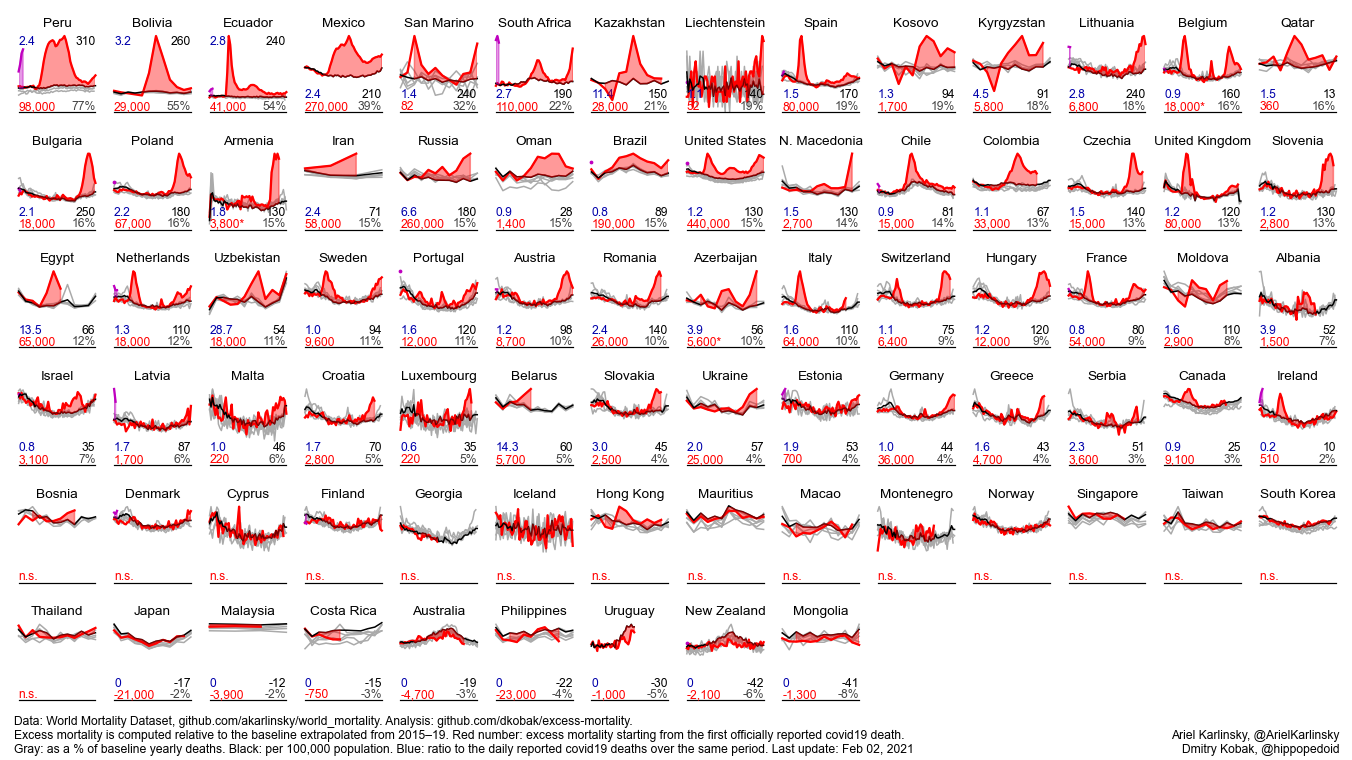

In [17]:
ds = np.zeros(len(allcountries))
for i,country in enumerate(allcountries.keys()):
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 
    d = total_excess/np.sum(baseline)*100
    if np.abs(total_excess)/total_excess_std < 2:
        d = 0 - ord(country[0])/100 - ord(country[1])/1000
    ds[i] = d
ind = np.argsort(ds)[::-1]

fig = plt.figure(figsize=(8*1.55,4.5*1.55))

for i,country in enumerate(np.array(list(allcountries.keys()))[ind]):
    plt.subplot(6,14,i+1)
    
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 

    for year in np.arange(X[0,0],2020):
        plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], color='#aaaaaa', lw=1, clip_on=False)
    plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], color='r', lw=1.5, clip_on=False)
    if np.sum(X[:,0]==2021)>1:
        plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], color='m', lw=1.5, clip_on=False)
    elif np.sum(X[:,0]==2021)==1:
        plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], '.', color='m', markersize=3, clip_on=False)
    plt.plot(np.arange(baseline.size)+1, baseline, color='k', lw=1, clip_on=False)

    if i>=3: #np.max(X[:,-1]) < np.mean(baseline) * 2.75:
        toplabel = .3
    else:
        toplabel = 1
        
    if country in ['Belgium','Armenia','Azerbaijan']:
        star = '*'
    else:
        star = ''

    fs = 8
    thresh = 2
    z = np.abs(total_excess)/total_excess_std
    if np.isnan(z) or z > thresh:
        plt.text(.0, .03, f'{round_to_n(total_excess,2):,.0f}'+star, transform=plt.gca().transAxes,
                     color='r', fontsize=fs)
        plt.text(1, .03, f'{total_excess/np.sum(baseline)*100:.0f}%', transform=plt.gca().transAxes, 
                 ha='right', color='#444444', fontsize=fs)
        plt.text(1, toplabel, f'{round_to_n(total_excess/pops[ind][i]*100000,2):.0f}', transform=plt.gca().transAxes, 
                 ha='right', va='top', color='k', fontsize=fs)
        if total_excess>0:
            plt.text(.0, toplabel, f'{total_excess/official[ind][i]:.1f}', transform=plt.gca().transAxes, 
                     va='top', color='#0000aa', fontsize=fs)
        else:
            plt.text(.0, toplabel, '0', transform=plt.gca().transAxes, 
                     va='top', color='#0000aa', fontsize=fs)
    else:
        plt.text(.0, .03, 'n.s.', transform=plt.gca().transAxes,
            color='r', fontsize=fs)
        
    poly1 = np.concatenate((X[X[:,0]==2020, 1][excess_begin:], X[X[:,0]==2020, 1][excess_begin:][::-1]))
    poly2 = np.concatenate((X[X[:,0]==2020, 2][excess_begin:], baseline[X[X[:,0]==2020, 1]-1][excess_begin:][::-1]))
    poly = np.concatenate((poly1[:,np.newaxis], poly2[:,np.newaxis]), axis=1)
    poly = Polygon(poly, facecolor='r', edgecolor='r', alpha=.4, zorder=5)
    plt.gca().add_patch(poly)
    
    if np.sum(X[:,0]==2021)>1:
        poly1 = np.concatenate((X[X[:,0]==2021, 1], X[X[:,0]==2021, 1][::-1]))
        poly2 = np.concatenate((X[X[:,0]==2021, 2], baseline[X[X[:,0]==2021, 1]-1][::-1]))
        poly = np.concatenate((poly1[:,np.newaxis], poly2[:,np.newaxis]), axis=1)
        poly = Polygon(poly, facecolor='m', edgecolor='m', alpha=.4, zorder=5)
        plt.gca().add_patch(poly)
    
    plt.ylim([0,np.nanmax(X[:,-1])])
    plt.xlim([1, baseline.size])
    
    # For Uruguay:
    if baseline.size > 12 and baseline.size < 50:
        plt.xlim([1,53])
        
    plt.xticks([])
    plt.yticks([])
    plt.title(country if country!='North Macedonia' else 'N. Macedonia', 
              fontsize=9)
        
sns.despine(left=True)
plt.tight_layout(rect=(0,.05,1,1))

fig.text(.01,.005, 
'Data: World Mortality Dataset, github.com/akarlinsky/world_mortality. '
'Analysis: github.com/dkobak/excess-mortality.\n'
'Excess mortality is computed relative to the baseline extrapolated from 2015–19. '
'Red number: excess mortality starting from the first officially reported covid19 death.\n'
'Gray: as a % of baseline yearly deaths. '
'Black: per 100,000 population. '
'Blue: ratio to the daily reported covid19 deaths over the same period. '
f'Last update: {datetime.date.today():%b %d, %Y}', fontsize=8, va='bottom')

fig.text(.99,.005, 'Ariel Karlinsky, @ArielKarlinsky\nDmitry Kobak, @hippopedoid', 
         fontsize=8, ha='right', va='bottom')

plt.savefig('img/all-countries.png', dpi=200)

In [18]:
def until_date(country):
    howmany = np.max(allcountries[country][0][:,1])
    last = allcountries[country][0][-1][1]
    lastyear = allcountries[country][0][-1][0]

    if howmany>12:
        date = datetime.datetime.strptime(f'{lastyear}-W{last:02}-0', "%G-W%V-%w")
    elif howmany==12:
        if last<12:
            date = datetime.datetime.strptime(f'{lastyear}-{last+1:02}-01', "%Y-%m-%d")
        else:
            date = datetime.datetime.strptime(f'{lastyear+1}-01-01', "%Y-%m-%d")
        date -= datetime.timedelta(days=1)
    else:
        if last<4:
            date = datetime.datetime.strptime(f'{lastyear}-{last*3+1:02}-01', "%Y-%m-%d")
        else:
            date = datetime.datetime.strptime(f'{lastyear+1}-01-01', "%Y-%m-%d")
        date -= datetime.timedelta(days=1)
        
        if country=='Iran':
            if last>1:
                date = datetime.datetime.strptime(f'{lastyear}-{last*3:02}-21', "%Y-%m-%d")
            else:
                date = datetime.datetime.strptime(f'{lastyear-1}-12-21', "%Y-%m-%d")

    date = date.strftime('%b %d, %Y')
    
    if howmany>12:
        time_format = 'w'
    elif howmany==12:
        time_format = 'm'
    else:
        time_format = 'q'
    
    return date, time_format
    

print('Country                     Until  Type   Confirmed      Excess      std      t  Undercount  Per 100k   Increase')
print('----------------------------------------------------------------------------------------------------------------')

for i,c in enumerate(allcountries):
    until, time_format = until_date(c)
    thresh = 2
    
    z = np.abs(allcountries[c][2])/allcountries[c][4]
    if np.isnan(z) or z > thresh:
        undercount = f'        {round_to_n(np.max((0,allcountries[c][2]))/official[i],2):4.1f}' 
        per100k    = f'      {round_to_n(allcountries[c][2]/pops[i]*1e+5,2):4.0f}'
        increase   = f'        {allcountries[c][2]/np.sum(allcountries[c][1])*100:2.0f}%'

    else:
        undercount = ''
        per100k    = ''
        increase   = ''
    
    print(f'{c:20} {until:15}  {time_format}     {round_to_n(official[i],2):7,.0f}'
          f'     {round_to_n(allcountries[c][2],2):7,.0f} ± {round_to_n(allcountries[c][4],2):6,.0f}' 
          f'  {z:5.1f}' + undercount + per100k + increase)

Country                     Until  Type   Confirmed      Excess      std      t  Undercount  Per 100k   Increase
----------------------------------------------------------------------------------------------------------------
Albania              Sep 27, 2020     w         380       1,500 ±    350    4.3         3.9        52         7%
Armenia              Nov 29, 2020     w       2,100       3,800 ±    600    6.4         1.8       130        15%
Australia            Oct 25, 2020     w         900      -4,700 ±    750    6.3         0.0       -19        -3%
Austria              Jan 17, 2021     w       7,100       8,700 ±  1,000    8.5         1.2        98        10%
Azerbaijan           Nov 30, 2020     m       1,400       5,600 ±  1,200    4.7         3.9        56        10%
Belarus              Jun 30, 2020     m         400       5,700 ±    930    6.1        14.0        60         5%
Belgium              Jan 17, 2021     w      20,000      18,000 ±  1,300   13.5         0.9     

In [19]:
for i,c in enumerate(allcountries):
    until, time_format = until_date(c)
    thresh = 2
    
    z = np.abs(allcountries[c][2])/allcountries[c][4]
    if np.isnan(z) or z > thresh:
        undercount = f'{round_to_n(np.max((0,allcountries[c][2]))/official[i],2):.1f}' 
        per100k    = f'${round_to_n(allcountries[c][2]/pops[i]*1e+5,2):.0f}$'
        increase   = f'${allcountries[c][2]/np.sum(allcountries[c][1])*100:.0f}\%$'

    else:
        undercount = 'n.s.'
        per100k    = 'n.s.'
        increase   = 'n.s.'
        
    minus = '$-$' if allcountries[c][2]<0 else ''
    
    print(f'{c} & {until} & {time_format} & {round_to_n(official[i],2):,.0f} & '
          '' + minus + f'{round_to_n(np.abs(allcountries[c][2]),2):,.0f}'
          f'& $\pm\,${round_to_n(allcountries[c][4],2):,.0f} & ' 
          f'{z:.1f}' + ' & ' + undercount + ' & '  + per100k + ''
          ' & ' + increase + '\\\\')

Albania & Sep 27, 2020 & w & 380 & 1,500& $\pm\,$350 & 4.3 & 3.9 & $52$ & $7\%$\\
Armenia & Nov 29, 2020 & w & 2,100 & 3,800& $\pm\,$600 & 6.4 & 1.8 & $130$ & $15\%$\\
Australia & Oct 25, 2020 & w & 900 & $-$4,700& $\pm\,$750 & 6.3 & 0.0 & $-19$ & $-3\%$\\
Austria & Jan 17, 2021 & w & 7,100 & 8,700& $\pm\,$1,000 & 8.5 & 1.2 & $98$ & $10\%$\\
Azerbaijan & Nov 30, 2020 & m & 1,400 & 5,600& $\pm\,$1,200 & 4.7 & 3.9 & $56$ & $10\%$\\
Belarus & Jun 30, 2020 & m & 400 & 5,700& $\pm\,$930 & 6.1 & 14.0 & $60$ & $5\%$\\
Belgium & Jan 17, 2021 & w & 20,000 & 18,000& $\pm\,$1,300 & 13.5 & 0.9 & $160$ & $16\%$\\
Bolivia & Dec 31, 2020 & m & 9,200 & 29,000& $\pm\,$640 & 45.7 & 3.2 & $260$ & $55\%$\\
Bosnia & Sep 30, 2020 & m & 860 & 670& $\pm\,$710 & 0.9 & n.s. & n.s. & n.s.\\
Brazil & Jan 31, 2021 & m & 220,000 & 190,000& $\pm\,$18,000 & 10.7 & 0.8 & $89$ & $15\%$\\
Bulgaria & Jan 17, 2021 & w & 8,500 & 18,000& $\pm\,$1,300 & 13.5 & 2.1 & $250$ & $16\%$\\
Canada & Oct 18, 2020 & w & 9,900 & 9,100&

In [20]:
# Export undercounts

with open('undercount-ratios.csv','w') as f:
    for i,c in enumerate(allcountries):
        if official[i] > 0:
            undercount = np.max((0,allcountries[c][2]))/official[i]
        else:
            undercount = 0
        z = np.abs(allcountries[c][2])/allcountries[c][4]
        if z < 2:
            undercount = 0
        f.write(f'{c}, {undercount:.1f}\n')

<IPython.core.display.Javascript object>


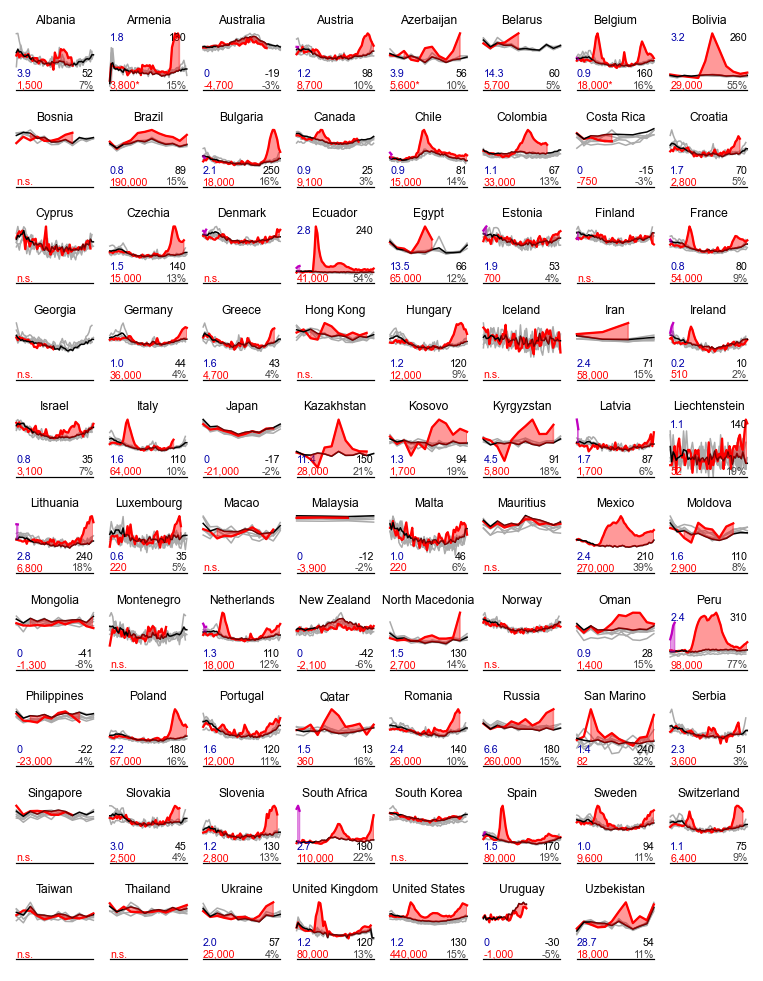

In [21]:
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Arial']

fig = plt.figure(figsize=(7,9))

for i,country in enumerate(allcountries.keys()):
    plt.subplot(10,8,i+1)
    
    X, baseline, total_excess, excess_begin, total_excess_std = allcountries[country] 

    for year in np.arange(X[0,0],2020):
        plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], color='#aaaaaa', lw=1, clip_on=False)
    plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], color='r', lw=1.5, clip_on=False)
    if np.sum(X[:,0]==2021)>1:
        plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], color='m', lw=1.5, clip_on=False)
    plt.plot(np.arange(baseline.size)+1, baseline, color='k', lw=1, clip_on=False)

    if np.max(X[:,-1]) < np.mean(baseline) * 2.75:
        toplabel = .37
    else:
        toplabel = 1
        
    if country in ['Belgium','Armenia','Azerbaijan']:
        star = '*'
    else:
        star = ''

    fs = 7
    thresh = 2
    z = np.abs(total_excess)/total_excess_std
    if np.isnan(z) or z > thresh:
#         if np.abs(total_excess)>100000:
#             plt.text(.0, .03, f'{np.round(total_excess/1000)*1000:,.0f}'+star, transform=plt.gca().transAxes,
#                      color='r', fontsize=fs)
#         elif np.abs(total_excess)>1000:
#             plt.text(.0, .03, f'{np.round(total_excess/100)*100:,.0f}'+star, transform=plt.gca().transAxes,
#                      color='r', fontsize=fs)
#         else:
        plt.text(.0, .03, f'{round_to_n(total_excess,2):,.0f}'+star, transform=plt.gca().transAxes,
                     color='r', fontsize=fs)
        plt.text(1, .03, f'{total_excess/np.sum(baseline)*100:.0f}%', transform=plt.gca().transAxes, 
                 ha='right', color='#444444', fontsize=fs)
        plt.text(1, toplabel, f'{round_to_n(total_excess/pops[i]*100000,2):.0f}', transform=plt.gca().transAxes, 
                 ha='right', va='top', color='k', fontsize=fs)
        if total_excess>0:
            plt.text(.0, toplabel, f'{total_excess/official[i]:.1f}', transform=plt.gca().transAxes, 
                     va='top', color='#0000aa', fontsize=fs)
        else:
            plt.text(.0, toplabel, '0', transform=plt.gca().transAxes, 
                     va='top', color='#0000aa', fontsize=fs)
    else:
        plt.text(.0, .03, 'n.s.', transform=plt.gca().transAxes,
            color='r', fontsize=fs)
        
    poly1 = np.concatenate((X[X[:,0]==2020, 1][excess_begin:], X[X[:,0]==2020, 1][excess_begin:][::-1]))
    poly2 = np.concatenate((X[X[:,0]==2020, 2][excess_begin:], baseline[X[X[:,0]==2020, 1]-1][excess_begin:][::-1]))
    poly = np.concatenate((poly1[:,np.newaxis], poly2[:,np.newaxis]), axis=1)
    poly = Polygon(poly, facecolor='r', edgecolor='r', alpha=.4, zorder=5)
    plt.gca().add_patch(poly)
    
    if np.sum(X[:,0]==2021)>1:
        poly1 = np.concatenate((X[X[:,0]==2021, 1], X[X[:,0]==2021, 1][::-1]))
        poly2 = np.concatenate((X[X[:,0]==2021, 2], baseline[X[X[:,0]==2021, 1]-1][::-1]))
        poly = np.concatenate((poly1[:,np.newaxis], poly2[:,np.newaxis]), axis=1)
        poly = Polygon(poly, facecolor='m', edgecolor='m', alpha=.4, zorder=5)
        plt.gca().add_patch(poly)
    
    plt.ylim([0,np.nanmax(X[:,-1])])
    plt.xlim([1, baseline.size])
    
    # For Uruguay:
    if baseline.size > 12 and baseline.size < 50:
        plt.xlim([1,53])
        
    plt.xticks([])
    plt.yticks([])
    plt.title(country,# if country!='North Macedonia' else 'N. Macedonia', 
              fontsize=8)
        
sns.despine(left=True)
plt.tight_layout()

plt.savefig('img/all-countries-a4.pdf')

In [22]:
# # Placeholder to look stuff up

# country = 'Sweden'

# X,baseline,_,_,_ = allcountries[country] 
# plt.figure(figsize=(5,3))
# for year in np.arange(X[0,0],2020):
#     plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], color='#aaaaaa', lw=1)
# plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], color='r', lw=1.5, clip_on=False)
# plt.plot(X[X[:,0]==2020, 1][get_excess_begin('Sweden'):], 
#          X[X[:,0]==2020, 2][get_excess_begin('Sweden'):], '.', color='r', lw=1.5, clip_on=False)
# plt.plot(np.arange(baseline.size)+1, baseline, color='k', lw=1)

# for year in np.arange(X[0,0],2021):
#     print(np.sum(X[X[:,0]==year, 2]))

# # beg = excess_begin(country)
# # d = np.sum(diff[10:21])
# # d

# plt.title('Sweden')

# sns.despine()
# plt.tight_layout()
# plt.savefig('img/swe.png', dpi=100)

# # (X[X[:,0]==2020, 2] - baseline)

In [23]:
# X = allcountries['Belgium'][0]
# baseline = allcountries['Belgium'][1]

# plt.figure(figsize=(8*.75,4.5*.75))
# # a = 0
# for year in np.arange(2015,2020):
#     plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], label=year)
# #     a+=X[(X[:,0]==year)&(X[:,1]<53), 2]
# # a/=5

# plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], '.-', color='r', lw=2, label=2020)
# plt.plot(X[X[:,0]==2020, 1], baseline,'k' )    
# # plt.plot(X[X[:,0]==2020, 1], a, 'k--' )    
# plt.legend()

# np.sum(X[X[:,0]==2020, 2][31:34] - baseline[31:34])

In [24]:
# df = pd.read_csv('https://github.com/Financial-Times/coronavirus-excess-mortality-data/blob/master/data/ft_excess_deaths.csv?raw=true')
# X = df[(df['region']=='New York City')&(df['year']>=2015)][['year','week','deaths']].values

# plt.figure(figsize=(8*.75,4.5*.75))
# for year in np.arange(2015,2020):
#     plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], color='#aaaaaa', lw=1)
# plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], '.-', color='r', lw=1.5, clip_on=False)
# plt.xlim([1,53])
# plt.ylim([0,8000])
# plt.title('New York City')
# plt.xlabel('Week')
# plt.ylabel('Deaths per week')
# sns.despine()
# plt.tight_layout()

# print(np.sum(X[X[:,0]==2020, 2][10:25]-X[X[:,0]==2019, 2][10:25]))

# plt.savefig('img/nyc.png', dpi=100)

In [25]:
# X = allcountries['Ireland'][0]
# baseline = allcountries['Ireland'][1]

# plt.figure(figsize=(8*.75,4.5*.75))
# for year in np.arange(2015,2020):
#     plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], label=year)

# plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], '.-', color='r', lw=2, label=2020)
# plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], '.-', color='m', lw=2, label=2020)
# plt.plot(X[X[:,0]==2020, 1], baseline,'k' )    
# plt.legend()

# print(np.sum(X[X[:,0]==2020, 2][11:21] - baseline[11:21]))
# print(np.sum(X[X[:,0]==2020, 2][11:] - baseline[11:]))
# print(np.sum(X[X[:,0]==2021, 2][:3] - baseline[:3]))

In [26]:
# X = allcountries['Italy'][0]
# baseline = allcountries['Italy'][1]

# plt.figure(figsize=(8*.75,4.5*.75))
# for year in np.arange(2015,2020):
#     plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], label=year)

# plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], '.-', color='r', lw=2, label=2020)
# plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], '.-', color='m', lw=2, label=2020)
# plt.plot(np.arange(baseline.size)+1, baseline,'k' )    
# plt.legend()

In [27]:
# X = allcountries['Sweden'][0]
# baseline = allcountries['Sweden'][1]

# plt.figure(figsize=(8*.75,4.5*.75))
# for year in np.arange(2015,2020):
#     plt.plot(X[X[:,0]==year, 1], X[X[:,0]==year, 2], label=year)

# plt.plot(X[X[:,0]==2020, 1], X[X[:,0]==2020, 2], '.-', color='r', lw=2, label=2020)
# plt.plot(X[X[:,0]==2021, 1], X[X[:,0]==2021, 2], '.-', color='m', lw=2, label=2021)
# plt.plot(np.arange(baseline.size)+1, baseline,'k' )    
# plt.legend()

# plt.ylabel('Weekly deaths')
# plt.ylim([0,2600])
# plt.title('Sweden')
# sns.despine()
# plt.tight_layout()
# plt.savefig('img/swe.png', dpi=100)